# ARIMA 1: Auto correlation (ACF, PACF), Auto Regressive Models
- Revisão 
- Slide de intro aos modelos ARIMA/ARIMAX/SARIMAX
- Operador Lag
- Intro aos modelos AR
- Transformações para atingir estacionariedade
- ACF e PACF
- Ajuste de Modelos AR
- Modelos ARI

### Preparação


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.datasets import co2, get_rdataset
plt.rcParams["figure.figsize"] = [10, 3]
# Co2 (Tendência e Sazonalidade Aditiva)
co2_df = co2.load_pandas().data
co2_s = pd.Series(co2_df['co2'].ffill().resample('MS').mean(), name='Mauna Loa CO2')
# Air Passenger (Tendência e Sazonalidade Multiplicativa)
air_passengers = get_rdataset("AirPassengers").data
air_passengers.index = pd.date_range('1949', '1960-12', freq='MS')
airp_s = pd.Series(air_passengers['value'], name = 'Número de Passageiros')
# Séries com ações
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True).resample('MS').mean()
apple = pd.Series(closing_price['AAPL'], name='Preço de Fechamento Apple')
microsoft = pd.Series(closing_price['MSFT'], name='Preço de Fechamento Microsoft')
ibm = pd.Series(closing_price['IBM'], name='Preço de Fechamento IBM')
# Lancamentos Netflix
netf = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/netflix_titles.csv')
netf.index = pd.to_datetime(netf['date_added'], format='%B %d, %Y', errors = 'coerce')
lancamentos = netf.resample('MS').size()
netflix = pd.Series(lancamentos[lancamentos.index.year>2015],name='Lançamentos Netflix desde 2016')
# Lista com todas as séries
todas_series = [co2_s,airp_s,apple,microsoft,ibm, netflix]

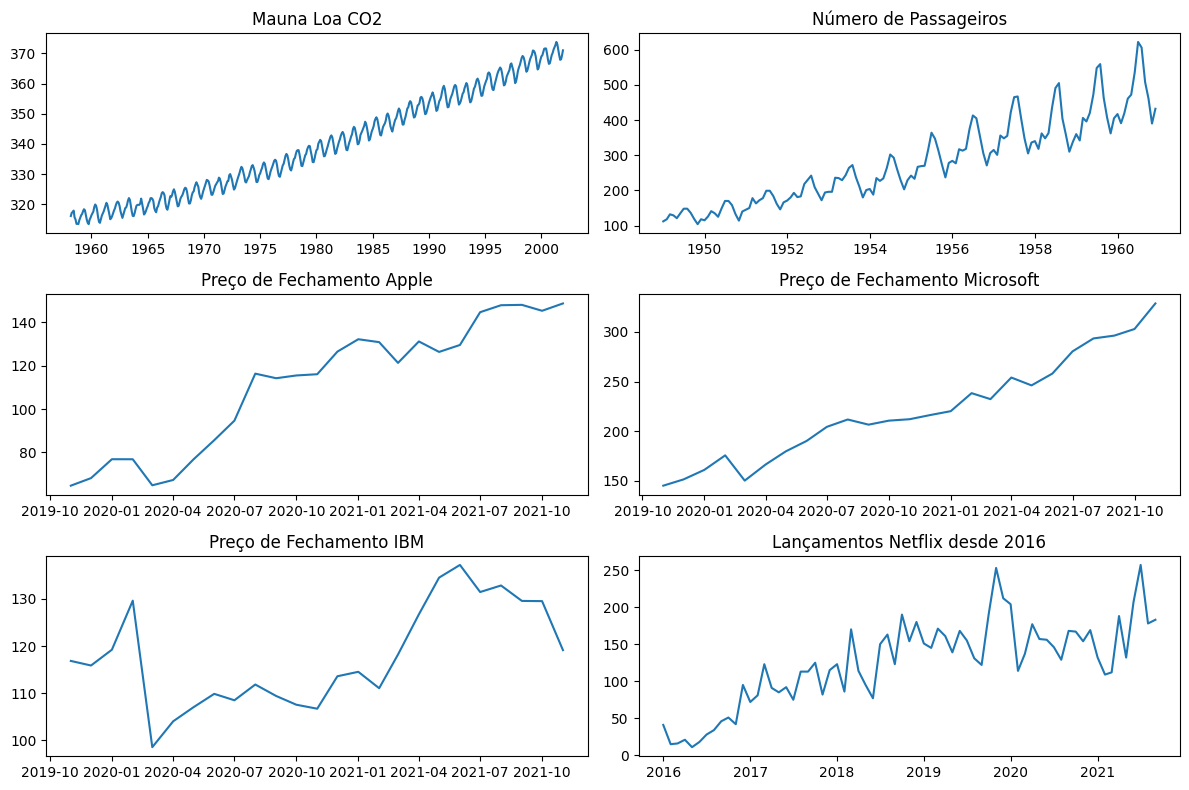

In [2]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))
axes = axes.flatten()
for i,s in enumerate(todas_series):
    ax = axes[i]
    ax.plot(s)
    ax.set_title(s.name)
plt.tight_layout()
plt.show()

### Operador Lag

In [3]:
np.random.seed(42)
y = pd.Series(np.random.randint(0, 20, size=10), index=pd.date_range(start='2025-01-01', periods=10))
y

2025-01-01     6
2025-01-02    19
2025-01-03    14
2025-01-04    10
2025-01-05     7
2025-01-06     6
2025-01-07    18
2025-01-08    10
2025-01-09    10
2025-01-10     3
Freq: D, dtype: int64

In [4]:
y.shift(1)

2025-01-01     NaN
2025-01-02     6.0
2025-01-03    19.0
2025-01-04    14.0
2025-01-05    10.0
2025-01-06     7.0
2025-01-07     6.0
2025-01-08    18.0
2025-01-09    10.0
2025-01-10    10.0
Freq: D, dtype: float64

In [5]:
df = pd.DataFrame({'Y':y, 'Yminus1': y.shift(1), 'Yminus2': y.shift(2), 'Yminus3': y.shift(3), 'Yminus4': y.shift(4)})
df

,Y,Yminus1,Yminus2,Yminus3,Yminus4
2025-01-01,6,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN
2025-01-05,7,10.0,14.0,19.0,6.0
2025-01-06,6,7.0,10.0,14.0,19.0
2025-01-07,18,6.0,7.0,10.0,14.0
2025-01-08,10,18.0,6.0,7.0,10.0
2025-01-09,10,10.0,18.0,6.0,7.0
2025-01-10,3,10.0,10.0,18.0,6.0


### Intro aos modelos AR
$$ \large Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \epsilon_t $$

In [6]:
df = pd.DataFrame({'Y':y, 'X1': y.shift(1), 'X2': y.shift(2), 'X3': y.shift(3), 'X4': y.shift(4)})
df

,Y,X1,X2,X3,X4
2025-01-01,6,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN
2025-01-05,7,10.0,14.0,19.0,6.0
2025-01-06,6,7.0,10.0,14.0,19.0
2025-01-07,18,6.0,7.0,10.0,14.0
2025-01-08,10,18.0,6.0,7.0,10.0
2025-01-09,10,10.0,18.0,6.0,7.0
2025-01-10,3,10.0,10.0,18.0,6.0


In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

def teste_estacionariedade(s):
    kps = kpss(s)
    adf = adfuller(s)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Estacionário', 'Não Estacionário'
    
    if adf_pv < 0.05:
        adfh = 'Estacionário'
    if kpss_pv < 0.05:
        kpssh = 'Não Estacionário'
    return (kpssh, adfh)

def mostra_series_com_testes(series, n_rows, n_cols,figsize=(12, 8)):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    axes = axes.flatten()
    for i,s in enumerate(series):
        ax = axes[i]
        ax.plot(s)
        ax.set_title(f'{s.name} - KPSS: {teste_estacionariedade(s)[0]} ADF: {teste_estacionariedade(s)[1]}', fontsize=10)
    plt.tight_layout()
    plt.show()

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1854/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(s)
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1854/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(s)
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1854/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kps = kpss(s)
/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_1854/4102516517.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value

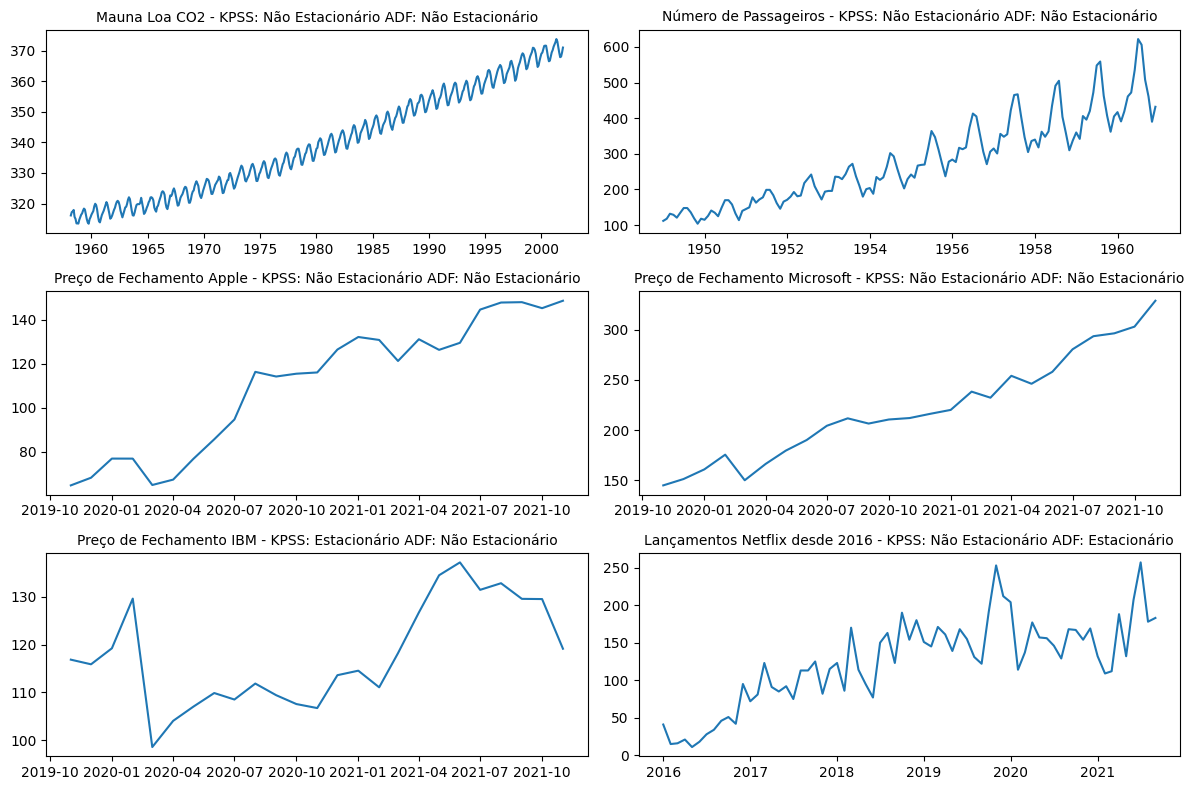

In [8]:
mostra_series_com_testes(todas_series,3,2)

## Transformações para atingir estacionariedade

- Diferenciação
    - Primeira Ordem
    - Segunda Ordem
    - Sazonal
- Log(Diferença Percentual)

### Diff Primeira Ordem

$$ \large y'_t = y_t - y_{t-1}  $$

In [9]:
serie_original = co2_s
primeira_ordem = serie_original.diff().dropna()
primeira_ordem

1958-04-01    1.100
1958-05-01    0.220
1958-06-01    0.480
1958-07-01   -2.275
1958-08-01   -0.665
              ...  
2001-08-01   -1.875
2001-09-01   -1.545
2001-10-01    0.170
2001-11-01    1.325
2001-12-01    1.645
Freq: MS, Name: Mauna Loa CO2, Length: 525, dtype: float64

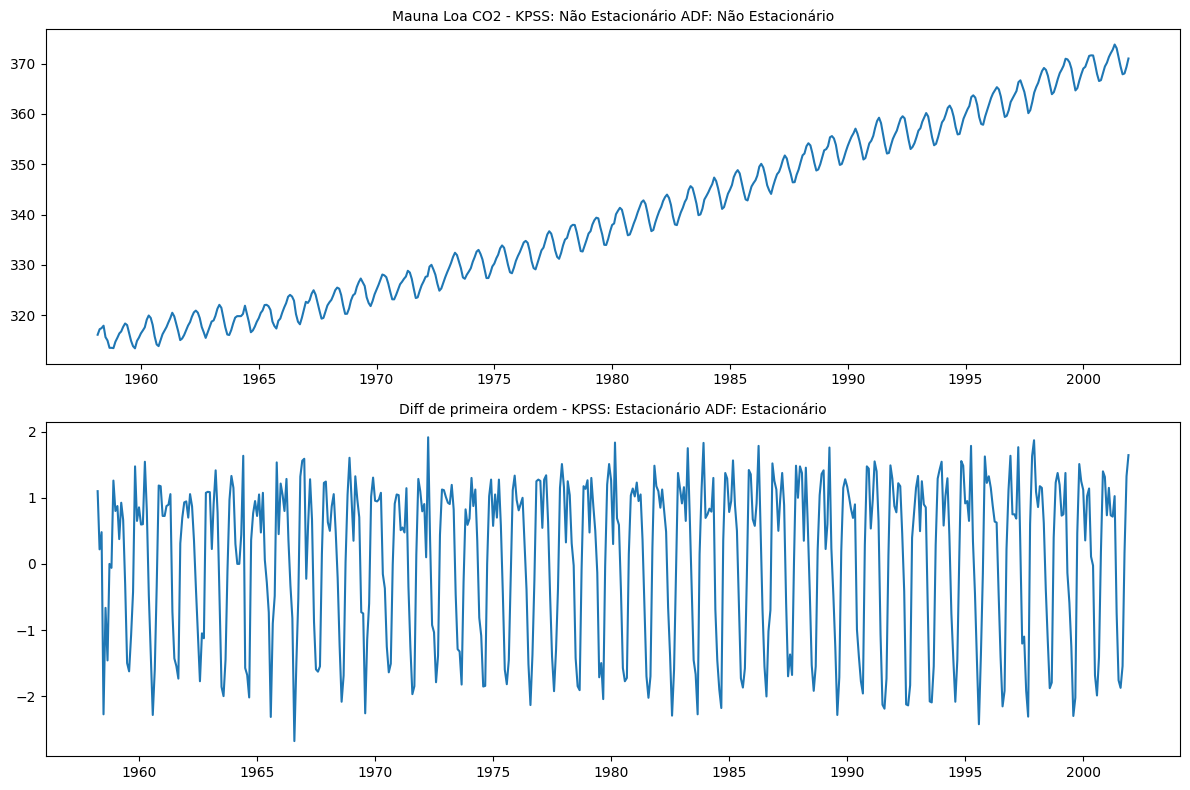

In [10]:
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings("ignore", category=InterpolationWarning)

primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')
series = [serie_original, primeira_ordem]
mostra_series_com_testes(series,2,1)

### Diff Segunda Ordem
$$ \large y'_t = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) $$

In [11]:
segunda_ordem = serie_original.diff().diff().dropna()
segunda_ordem = pd.Series(segunda_ordem, name = 'Diff de segunda ordem')

### Diff Sazonal
$$ \large y'_t = y_t - y_{t-12} $$

In [12]:
diff_sazonal = serie_original.diff(12).dropna()
diff_sazonal = pd.Series(diff_sazonal, name = 'Diff Sazonal')

### log diff

$$ \large y'_t = \log(y_t) - \log(y_{t-1}) = \log\left(\frac{y_t}{y_{t-1}}\right) $$

In [13]:
log_diff = np.log(serie_original/serie_original.shift(1)).dropna()
log_diff = pd.Series(log_diff, name = 'Diferença logarítmica')

### Box-Cox
$$ \large y_t^{(\lambda)} =
\begin{cases}
\frac{y_t^\lambda - 1}{\lambda}, & \lambda \neq 0 \\
\log(y_t), & \lambda = 0
\end{cases} $$

Box-Cox não retira tendência e só pode ser aplicada em séries positivas.

In [14]:
from scipy.stats import boxcox
boxcox_transform, lmbda = boxcox(serie_original)
boxcox_transform = pd.Series(boxcox_transform, index = serie_original.index, name = f'Box-Cox Transformation Lambda={round(lmbda,2)}')

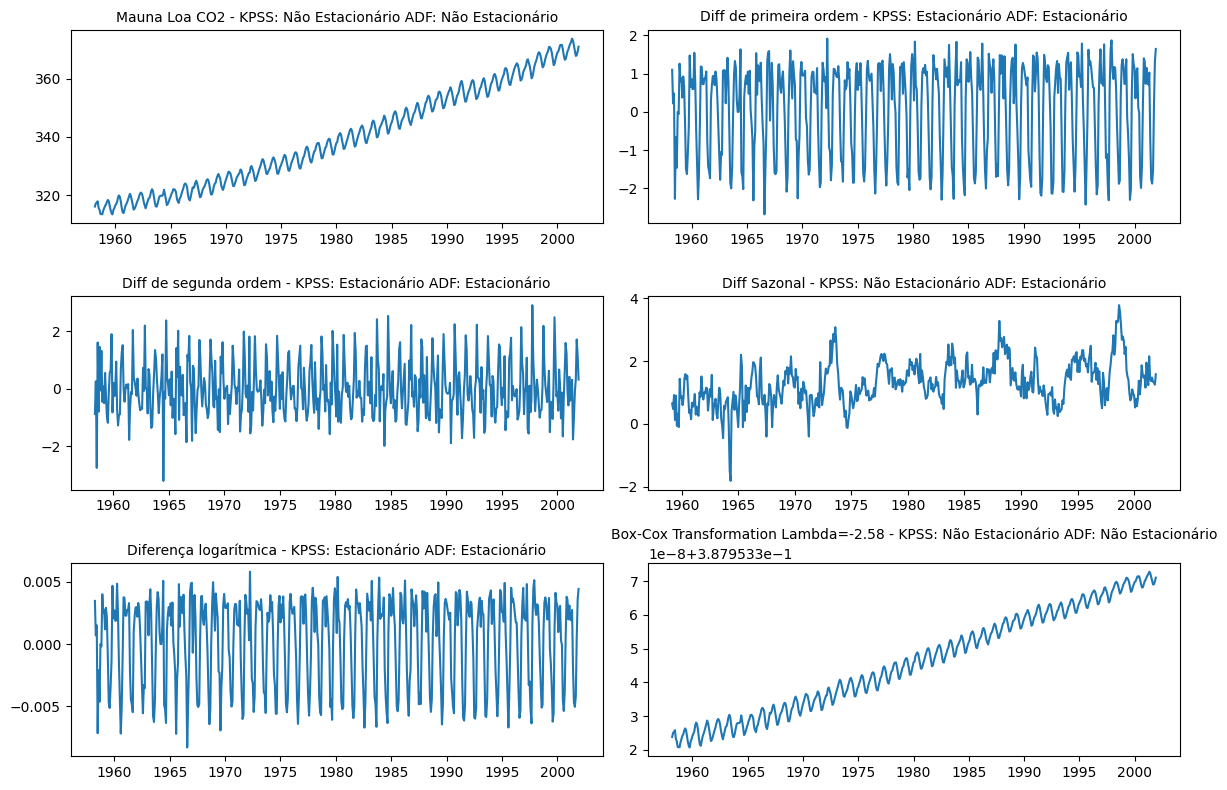

In [15]:
series = [serie_original, primeira_ordem, segunda_ordem, diff_sazonal, log_diff, boxcox_transform]
mostra_series_com_testes(series,3,2)

In [16]:
def testa_transformacoes(serie_original):
    primeira_ordem = serie_original.diff().dropna()
    primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')

    segunda_ordem = serie_original.diff().diff().dropna()
    segunda_ordem = pd.Series(segunda_ordem, name = 'Diff de segunda ordem')

    diff_sazonal = serie_original.diff(12).dropna()
    diff_sazonal = pd.Series(diff_sazonal, name = 'Diff Sazonal')

    log_diff = np.log(serie_original/serie_original.shift(1)).dropna()
    log_diff = pd.Series(log_diff, name = 'Diferença logarítmica')

    boxcox_transform, lmbda = boxcox(serie_original)
    boxcox_transform = pd.Series(boxcox_transform, index = serie_original.index, name = f'Box-Cox Transformation Lambda={round(lmbda,2)}')

    series = [serie_original, primeira_ordem, segunda_ordem, diff_sazonal, log_diff, boxcox_transform]
    mostra_series_com_testes(series,3,2)

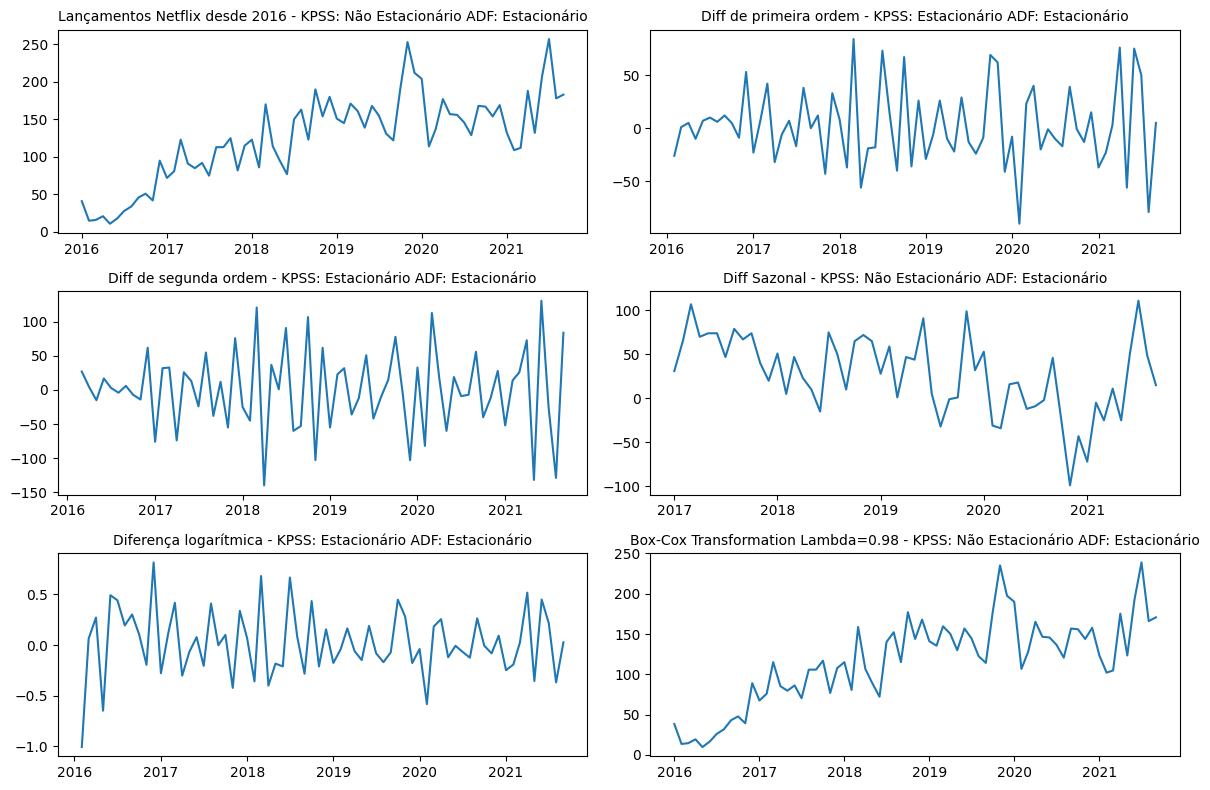

In [17]:
serie_original = netflix
testa_transformacoes(serie_original)

## ACF e PACF

Já vimos sobre o operador lag. Auto Correlação é a ideia de calcular a correlação da série com ela mesmo defasada. 

In [18]:
np.random.seed(42)
y = pd.Series(np.random.randint(0, 20, size=20), index=pd.date_range(start='2025-01-01', periods=20))
df = pd.DataFrame({'Y':y, 'Yminus1': y.shift(1), 'Yminus2': y.shift(2), 'Yminus3': y.shift(3), 'Yminus4': y.shift(4), 'Yminus5':y.shift(5)})
df

,Y,Yminus1,Yminus2,Yminus3,Yminus4,Yminus5
2025-01-01,6,NaN,NaN,NaN,NaN,NaN
2025-01-02,19,6.0,NaN,NaN,NaN,NaN
2025-01-03,14,19.0,6.0,NaN,NaN,NaN
2025-01-04,10,14.0,19.0,6.0,NaN,NaN
2025-01-05,7,10.0,14.0,19.0,6.0,NaN
2025-01-06,6,7.0,10.0,14.0,19.0,6.0
2025-01-07,18,6.0,7.0,10.0,14.0,19.0
2025-01-08,10,18.0,6.0,7.0,10.0,14.0
2025-01-09,10,10.0,18.0,6.0,7.0,10.0
2025-01-10,3,10.0,10.0,18.0,6.0,7.0


In [19]:
corr_matrix = df.corr(method='pearson')
corr_matrix[0:1]

,Y,Yminus1,Yminus2,Yminus3,Yminus4,Yminus5
Y,1.0,0.281563,0.031537,-0.206726,0.106213,0.258889


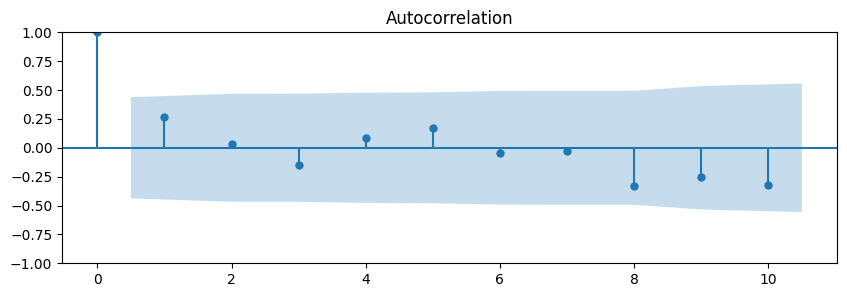

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(y)
plt.show()

Ok, vamos olhar para uma série que possui auto correlações:

<Axes: >

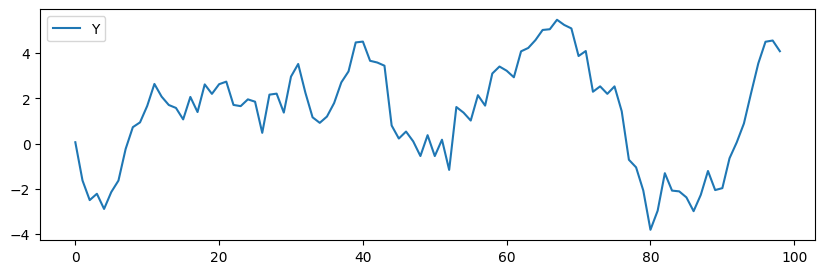

In [21]:
Y = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/AR1.csv')
Y.plot()

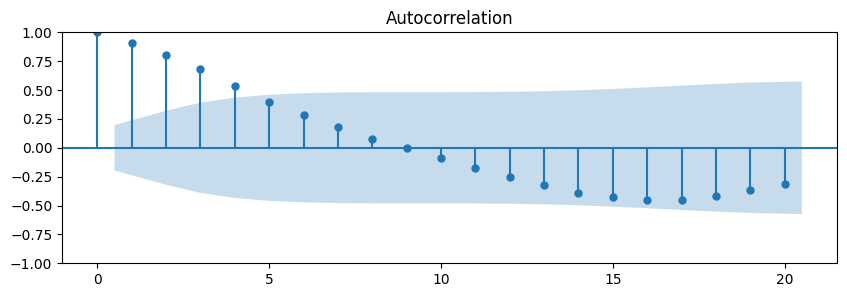

In [22]:
plot_acf(Y)
plt.show()

- ACF inclui todas as correlações entre os lags, mesmo as indiretas.
- PACF remove a influência dos defasagens intermediárias usando regressão e extraindo apenas o efeito direto de cada defasagem.
$$ Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \dots + \phi_k Y_{t-k} + \epsilon_t $$

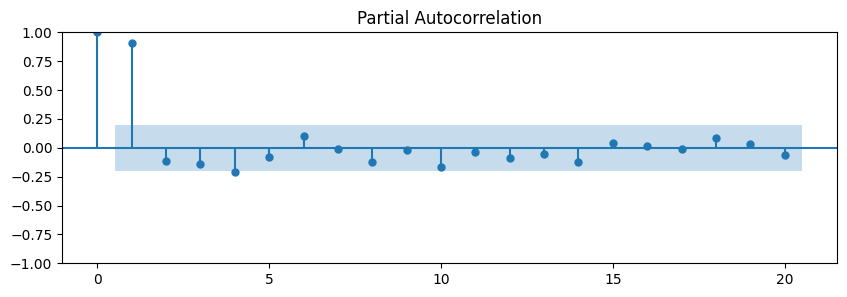

In [23]:
plot_pacf(Y)
plt.show()

### Testando se a série é um ruído branco

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

co2_diff = co2_s.diff().dropna()
acorr_ljungbox(co2_diff, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,254.280444,3.028972e-57
2,286.262856,6.899389e-63
3,309.294120,9.686313e-67
4,419.200509,1.973445e-89
5,560.703885,6.236474e-119
6,699.552649,7.640231e-148
7,837.502814,1.494457e-176
8,941.655439,5.825382e-198
9,960.010148,7.216603e-201
10,992.522264,7.632487e-207


In [25]:
acorr_ljungbox(Y, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,83.937296,5.107190e-20
2,150.317090,2.285908e-33
3,198.822928,7.576894e-43
4,229.216804,1.946224e-48
5,245.652286,4.708437e-51
6,254.081882,5.501925e-52
7,257.529717,6.910309e-52
8,258.157812,3.208411e-51
9,258.159249,1.886395e-50
10,259.107421,6.586253e-50


Exemplo de ruído branco:

<Axes: >

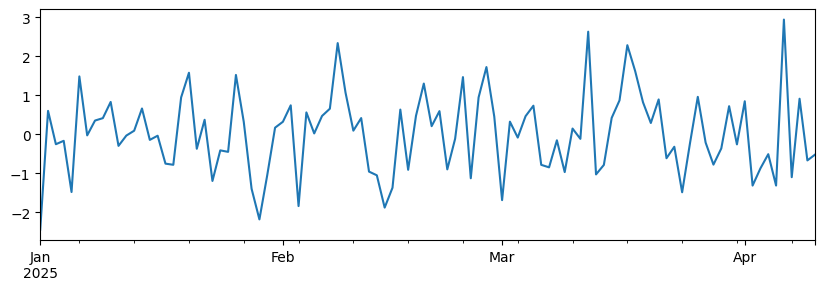

In [26]:
RB = pd.Series(np.random.normal(0, 1, 100), index=pd.date_range(start='2025-01-01', periods=100))
RB.plot()

In [27]:
acorr_ljungbox(RB, lags=10, return_df=True)

,lb_stat,lb_pvalue
1,0.215828,0.642237
2,0.416142,0.812149
3,2.392069,0.495113
4,3.047577,0.549895
5,3.117170,0.681927
6,3.123775,0.793159
7,3.136068,0.872136
8,4.232647,0.835547
9,6.402728,0.699032
10,8.822159,0.549061


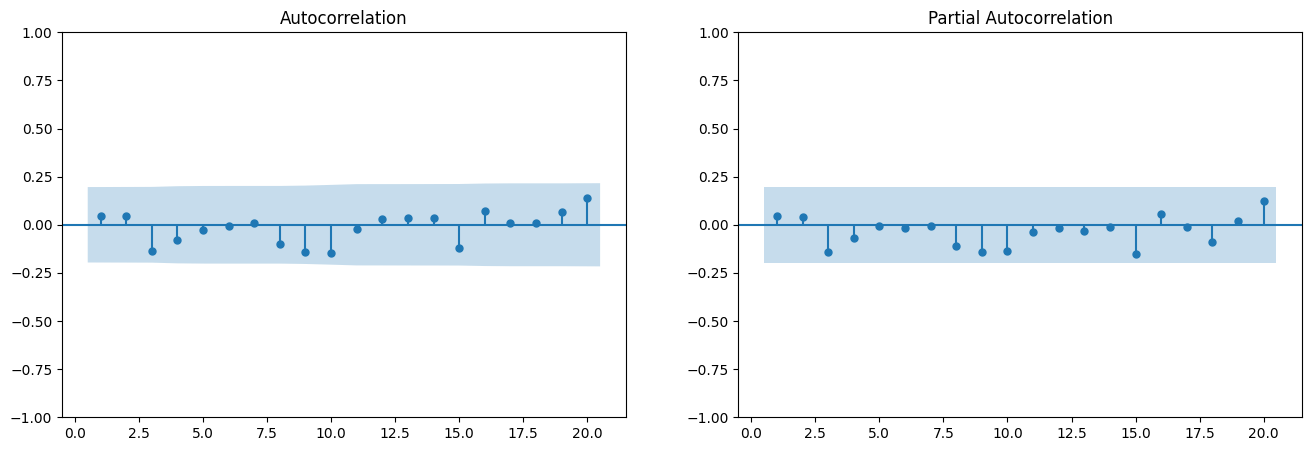

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(RB, zero=False, ax=ax[0])
plot_pacf(RB, zero=False, ax=ax[1])
plt.show()


### AR(1)

$$ \large Y_t = \phi_0 + \phi_1 Y_{t-1} + \epsilon_t $$

<Axes: >

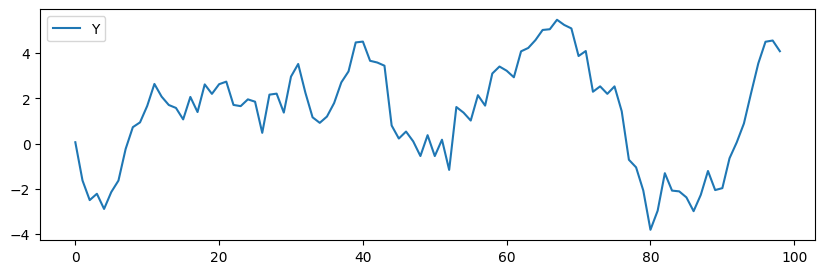

In [29]:
Y.plot()

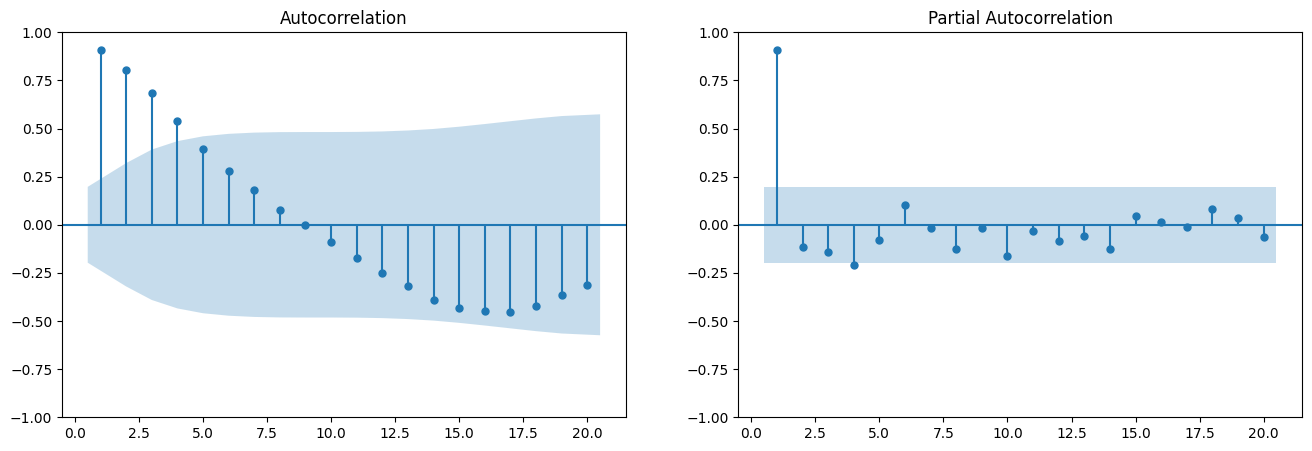

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(Y, zero=False, ax=ax[0])
plot_pacf(Y, zero=False, ax=ax[1])
plt.show()

### AR(2)
$$ \large Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \epsilon_t $$

### AR(p) Completo
$$ \large Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + ... + \phi_p Y_{t-p} + \epsilon_t $$

### AR(p) Incompletos
$$ \large Y_t = \phi_0 + \phi_4 Y_{t-4} + \epsilon_t $$
$$ \large Y_t = \phi_0 + \phi_2 Y_{t-2} + \phi_4 Y_{t-4} + \epsilon_t $$

### Ajustando um modelo usando Box e Jenkins

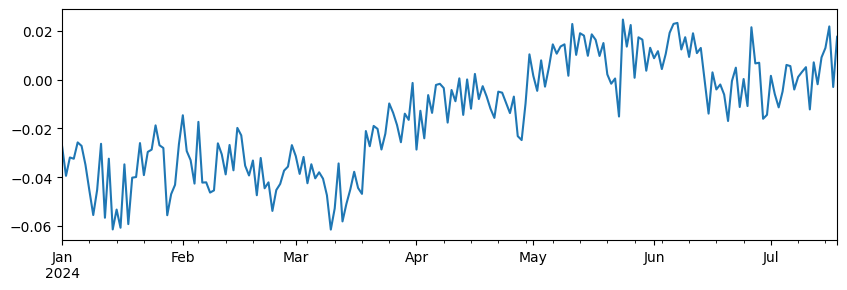

In [31]:
df = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/AR_Exemplo.csv')
Y = pd.Series(df['preco_diff'])
Y.index = pd.date_range(start='2024-01-01', periods=200)
Y.plot()
plt.show()

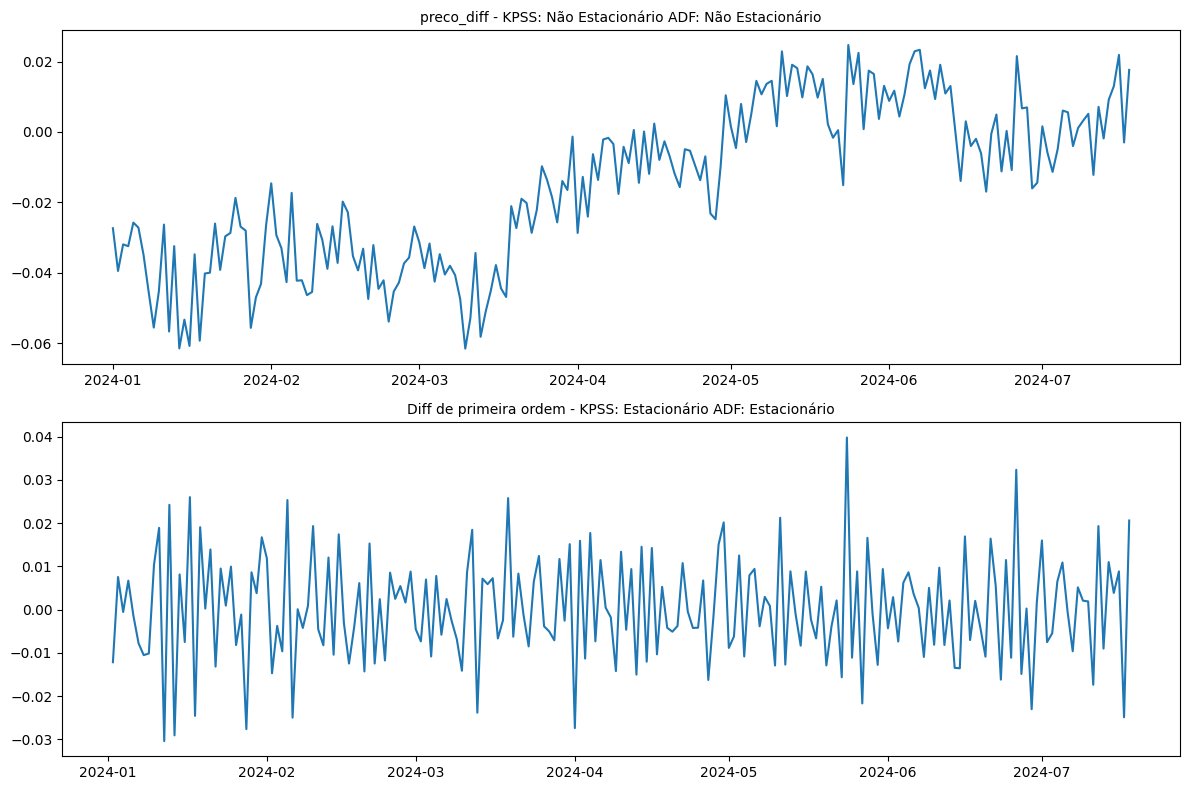

In [32]:
serie_original = Y
primeira_ordem = serie_original.diff().dropna()
primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')
series = [serie_original, primeira_ordem]
mostra_series_com_testes(series,2,1)

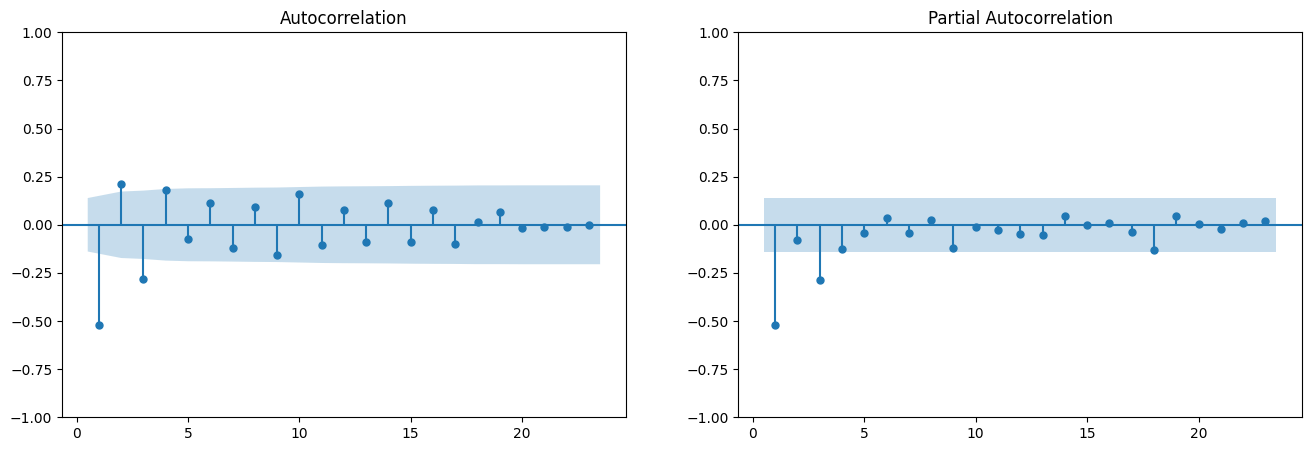

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(primeira_ordem, zero=False, ax=ax[0])
plot_pacf(primeira_ordem, zero=False, ax=ax[1])
plt.show()

In [34]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(primeira_ordem.dropna(), lags=1, trend='n').fit()
print("Model Parameters:")
print(model.params)
print("\nP-values:")
print(model.pvalues)

Model Parameters:
Diff de primeira ordem.L1   -0.52826
dtype: float64

P-values:
Diff de primeira ordem.L1    3.390352e-18
dtype: float64


In [35]:
model.resid

2024-01-03    0.001143
2024-01-04    0.003470
2024-01-05    0.006435
2024-01-06    0.002105
2024-01-07   -0.008532
                ...   
2024-07-14    0.006263
2024-07-15    0.009698
2024-07-16    0.010907
2024-07-17   -0.020204
2024-07-18    0.007486
Freq: D, Length: 198, dtype: float64

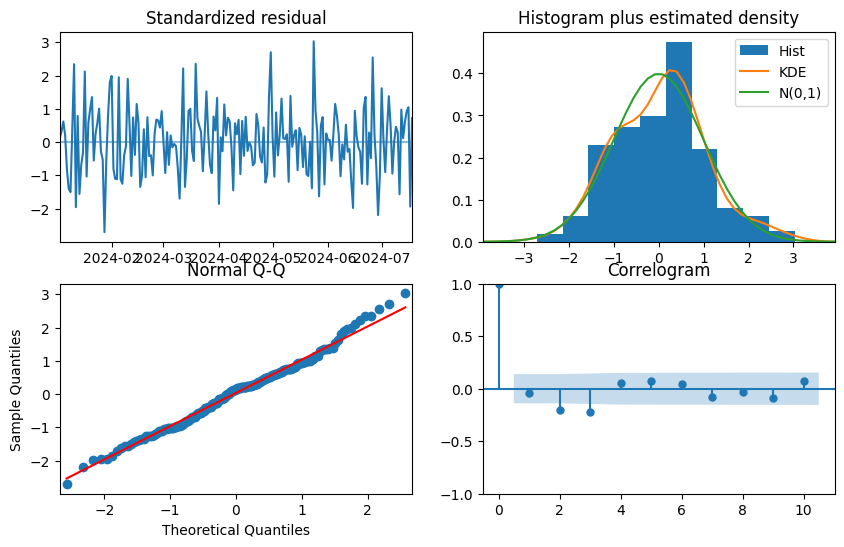

In [36]:
plt.rcParams["figure.figsize"] = [10, 6]
model.plot_diagnostics()
plt.show()

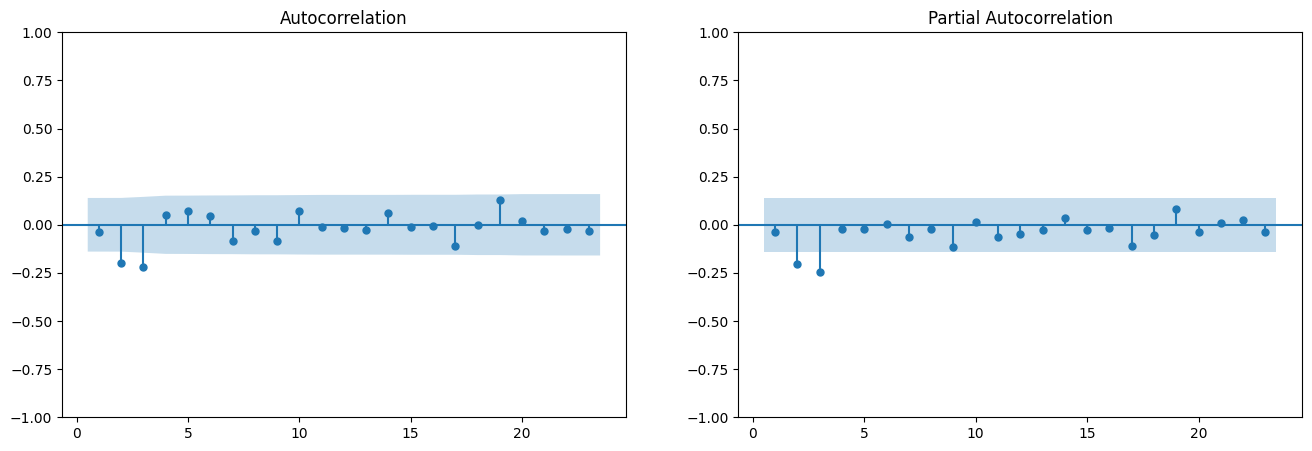

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(model.resid, zero=False, ax=ax[0])
plot_pacf(model.resid, zero=False, ax=ax[1])
plt.show()

In [38]:
model = AutoReg(primeira_ordem.dropna(), lags=2, trend='n').fit()
print("Model Parameters:")
print(model.params)
print("\nP-values:")
print(model.pvalues)

Model Parameters:
Diff de primeira ordem.L1   -0.566264
Diff de primeira ordem.L2   -0.074952
dtype: float64

P-values:
Diff de primeira ordem.L1    1.727387e-15
Diff de primeira ordem.L2    2.960222e-01
dtype: float64


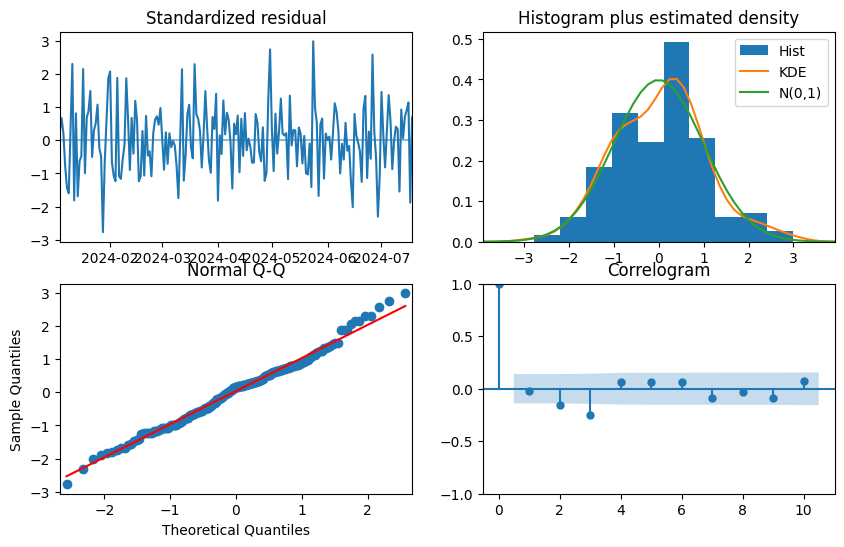

In [39]:
model.plot_diagnostics()
plt.show()

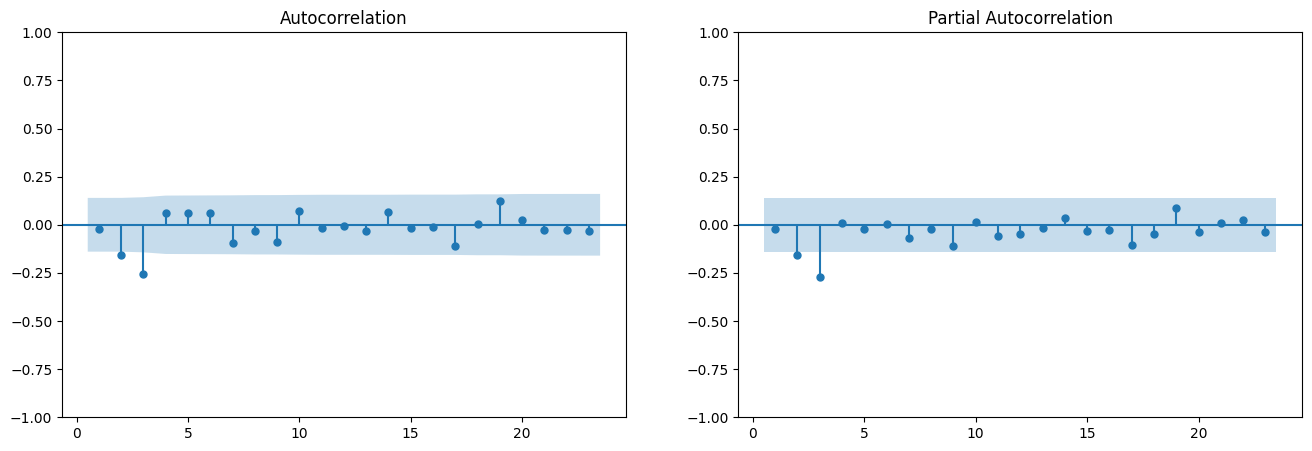

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(model.resid, zero=False, ax=ax[0])
plot_pacf(model.resid, zero=False, ax=ax[1])
plt.show()

In [41]:
model = AutoReg(primeira_ordem.dropna(), lags=3, trend='n').fit()
print("Model Parameters:")
print(model.params)
print("\nP-values:")
print(model.pvalues)

Model Parameters:
Diff de primeira ordem.L1   -0.587316
Diff de primeira ordem.L2   -0.233933
Diff de primeira ordem.L3   -0.288742
dtype: float64

P-values:
Diff de primeira ordem.L1    1.018479e-17
Diff de primeira ordem.L2    3.037178e-03
Diff de primeira ordem.L3    2.932650e-05
dtype: float64


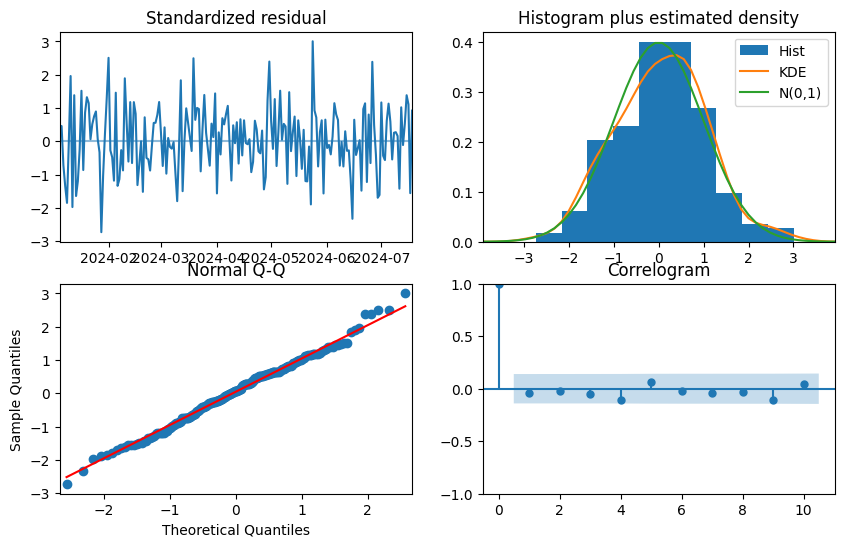

In [42]:
model.plot_diagnostics()
plt.show()

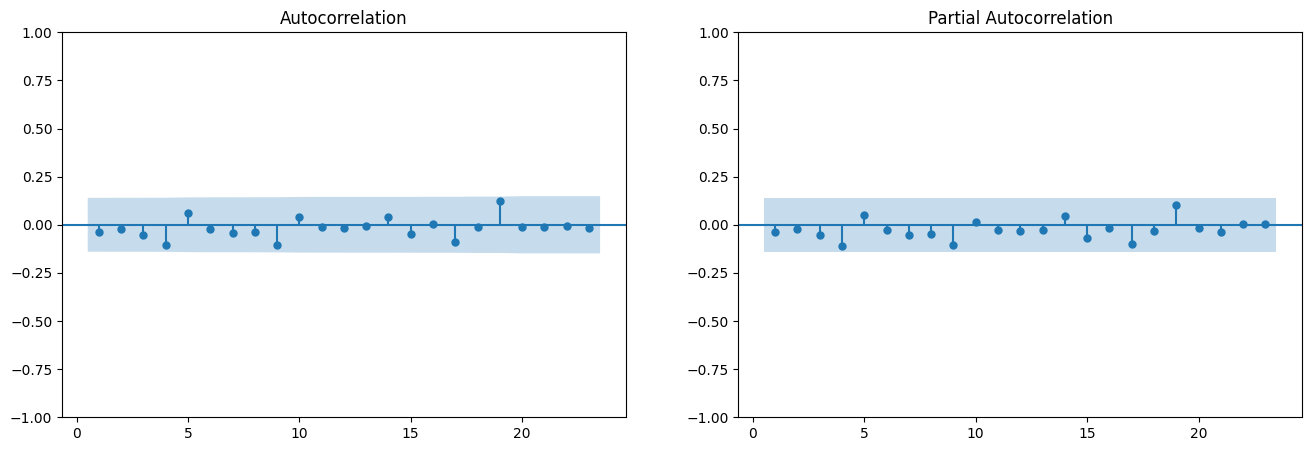

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(model.resid, zero=False, ax=ax[0])
plot_pacf(model.resid, zero=False, ax=ax[1])
plt.show()

In [44]:
model.forecast(20)

2024-07-19   -0.008853
2024-07-20    0.007558
2024-07-21   -0.008325
2024-07-22    0.005678
2024-07-23   -0.003569
2024-07-24    0.003172
2024-07-25   -0.002667
2024-07-26    0.001855
2024-07-27   -0.001381
2024-07-28    0.001148
2024-07-29   -0.000886
2024-07-30    0.000651
2024-07-31   -0.000506
2024-08-01    0.000401
2024-08-02   -0.000305
2024-08-03    0.000232
2024-08-04   -0.000180
2024-08-05    0.000140
2024-08-06   -0.000107
2024-08-07    0.000082
Freq: D, dtype: float64

In [45]:
model.forecast(20).cumsum()

2024-07-19   -0.008853
2024-07-20   -0.001295
2024-07-21   -0.009620
2024-07-22   -0.003942
2024-07-23   -0.007512
2024-07-24   -0.004340
2024-07-25   -0.007007
2024-07-26   -0.005152
2024-07-27   -0.006533
2024-07-28   -0.005386
2024-07-29   -0.006272
2024-07-30   -0.005621
2024-07-31   -0.006128
2024-08-01   -0.005727
2024-08-02   -0.006032
2024-08-03   -0.005800
2024-08-04   -0.005980
2024-08-05   -0.005841
2024-08-06   -0.005947
2024-08-07   -0.005865
Freq: D, dtype: float64

In [46]:
previsao = Y.iloc[-1] + model.forecast(20).cumsum()

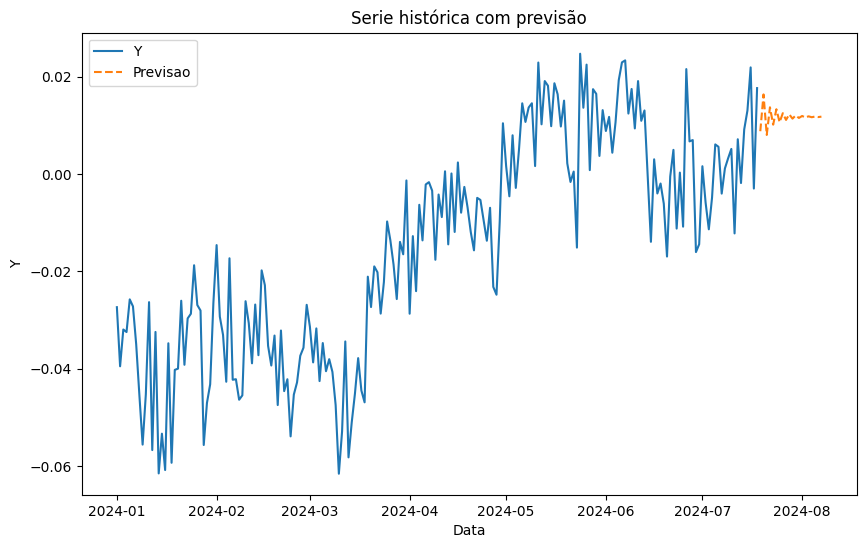

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(Y, label='Y', linestyle='-')  # Solid line for Y
plt.plot(previsao, label='Previsao', linestyle='--')  # Dashed line for previsao
plt.xlabel('Data')
plt.ylabel('Y')
plt.title('Serie histórica com previsão')
plt.legend()
plt.show()

## Tentativa de ajuste de um AR para as nossas séries

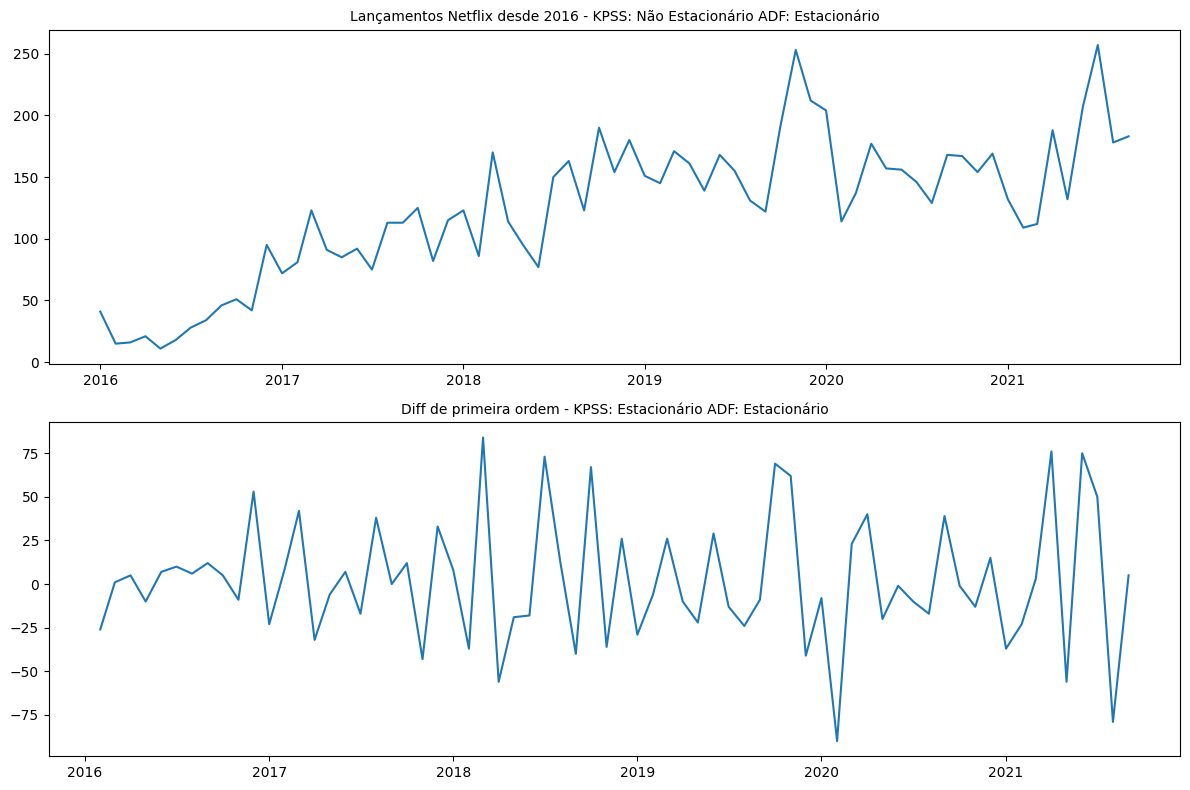

In [48]:
todas_series = [co2_s,airp_s,apple,microsoft,ibm, netflix]
serie_original = todas_series[5]
primeira_ordem = serie_original.diff().dropna()
primeira_ordem = pd.Series(primeira_ordem, name = 'Diff de primeira ordem')
series = [serie_original, primeira_ordem]
mostra_series_com_testes(series,2,1)

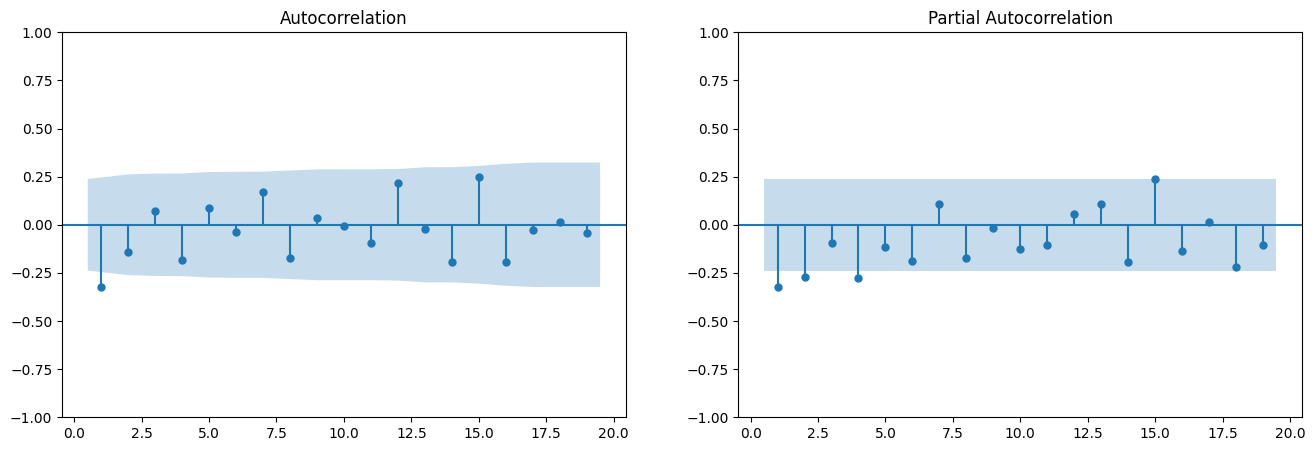

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_acf(primeira_ordem, zero=False, ax=ax[0])
plot_pacf(primeira_ordem, zero=False, ax=ax[1])
plt.show()